# CS4277/CS5477 Lab 3-1: Relative pose estimation with 8-point algorithm

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 1

%aimport eight_point

/home/csc/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import h5py
import scipy.io as sio
from eight_point import compute_fundamental, compute_essential, decompose_e
%matplotlib inline

### Introduction
In this assignment, you will get to estimate the essential and fundamental matrix by using eight point algorithm. As discussed in the lecture, images taken from different views should fulfill the epipolar constraint, which can be used to estimate the fundamental and essential matrix. You will first estimate the fundamental and essential matrix with 15 correspondences provided in the dataset. Then you will decompose the essential matrix to find rotation and translation between two views. The decomposition will give 4 feasible camera poses and you will select the the correct pose by chriality check.


This assignment is worth **10%** of the final grade.

References:
* Lecture 6

Optional references:
* Richard I. Hartley. In Defence of the 8-point Algorithm

### Instructions
This workbook provides the instructions for the assignment, and facilitates the running of your code and visualization of the results. For each part of the assignment, you are required to **complete the implementations of certain functions in the accompanying python file** (`eight_point.py`).

To facilitate implementation and grading, all your work is to be done in that file, and **you only have to submit the .py file**.

Please note the following:
1. Fill in your name, email, and NUSNET ID at the top of the python file.
2. The parts you need to implement are clearly marked with the following:

    ```
    """ YOUR CODE STARTS HERE """

    """ YOUR CODE ENDS HERE """
    ```
    
    , and you should write your code in between the above two lines.
3. Note that for each part, there may certain functions that are prohibited to be used. It is important **NOT to use those prohibited functions** (or other functions with similar functionality). If you are unsure whether a particular function is allowed, feel free to ask any of the TAs.


### Submission Instructions
Zip your completed `pnp.py` and `eight_point.py` and upload onto the relevant work bin in Luminus.

---
## Part 1: Load and Visualize Data

In this part, you will get yourself familiar with the data by
visualizing it. The data includes two images of the same object (im1.jpg and img2.jpg) and 15 correpondences (correspondences.mat). You can visualize the data with the provided code below.

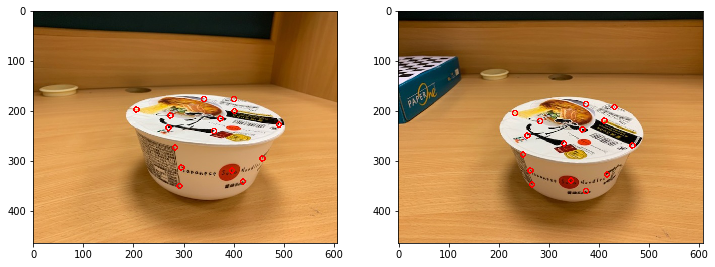

In [3]:
correspondences = sio.loadmat('data/correspondences_ud')
data1_ori = correspondences['movingPoints']
data2_ori = correspondences['fixedPoints']
data1 = np.concatenate([data1_ori.T, np.ones((1, data1_ori.shape[0]))], axis = 0)
data2 = np.concatenate([data2_ori.T, np.ones((1, data2_ori.shape[0]))], axis = 0)
img1 = plt.imread('data/img1.jpg')
img2 = plt.imread('data/img2.jpg')
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for j in range(data1_ori.shape[0]):
    cv2.circle(img1, (np.int32(data1_ori[j, 0]), np.int32(data1_ori[j, 1])) , 5, (255, 0, 0), 2)
plt.imshow(img1)
plt.subplot(1, 2, 2)
for j in range(data2_ori.shape[0]):
    cv2.circle(img2, (np.int32(data2_ori[j, 0]), np.int32(data2_ori[j, 1])) , 5, (255, 0, 0), 2)
plt.imshow(img2)

---
## Part 2: Estimate Fundamental Matrix from Point Correspondences

In this part, you will implement the 8-point algorithm to estimate the fundamental matrix. For any pair of matching points $\mathbf{x}_i \leftrightarrow \mathbf{x'}_i$ in two images, the $3 \times 3 $ fundamental matrix is defined by the equation:
$$
\mathbf{x'}^T \mathbf{F} \mathbf{x} = 0
$$
Let $\mathbf{f}$ be the 9-vector made up of the entries of $\mathbf{F}$ in row-major order, we get:
$$
(x'x, x'y, x', y'x, y'y, y', x, y, 1)\mathbf{f}=0
$$
From a set of $n$ point matches, we obtain a set of linear equations of the form:
$$
\mathbf{A}\mathbf{f} = 0
$$
The solution for $\mathbf{f}$ is the singlar vector corresponding to the smallest singular value of $\mathbf{A}$. Then you will enforce the singularity constraint to $\mathbf{F}$ matrix such that the rank of $\mathbf{F}$ is 2. Note that the normalization step is very important here to for accurate estimation.

You can verify your estimation by visualizing the epipolar lines in both images, where the epiploar lines will pass through all matching points. The helper function `plot_epipolar_line()` is provided for visualization

**Implement the following function(s): `cv2.findFundamentalMat()`**
* <u>Prohibited Functions</u>: `cv2.findFundamentalMat()`
* <u>You may use the following functions</u>:
  `np.linalg.svd()`

f [[ 2.86202756e-06 -4.53412838e-06  3.60919343e-03]
 [ 9.10864946e-06  2.00945480e-06  2.82976317e-03]
 [-5.94831446e-03 -6.72065323e-03  1.00000000e+00]]
N 15
valid [ 1  2  3  4  5  6  7  9 10 11 12 13]
f [[ 1.89381828e-06  7.10495970e-06 -4.77805874e-03]
 [-3.47952062e-06  4.80848923e-06 -5.14050872e-03]
 [ 3.06859706e-03  2.93798006e-04  1.00000000e+00]]
F [[ 1.89381828e-06  7.10495970e-06 -4.77805874e-03]
 [-3.47952062e-06  4.80848923e-06 -5.14050872e-03]
 [ 3.06859706e-03  2.93798006e-04  1.00000000e+00]]


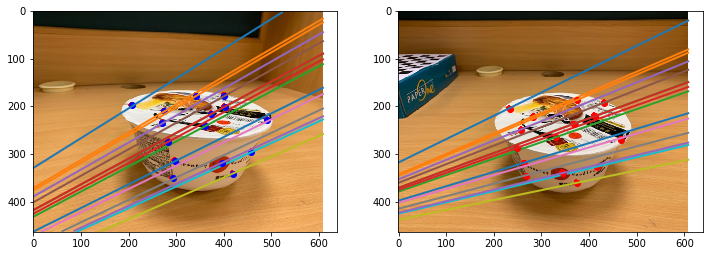

In [29]:
F = compute_fundamental(data1, data2)
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img1)
for i in range(data1.shape[1]):

  plt.plot(data1[0, i], data1[1, i], 'bo')
  m, n = img1.shape[:2]
  line1 = np.dot(F.T, data2[:, i])
  t = np.linspace(0, n, 100)
  lt1 = np.array([(line1[2] + line1[0] * tt) / (-line1[1]) for tt in t])
  ndx = (lt1 >= 0) & (lt1 < m)
  plt.plot(t[ndx], lt1[ndx], linewidth=2)

plt.subplot(1, 2, 2)
plt.imshow(img2)
for i in range(data2.shape[1]):
  plt.plot(data2[0, i], data2[1, i], 'ro')
  m, n = img2.shape[:2]
  line2 = np.dot(F, data1[:, i])
  t = np.linspace(0, n, 100)
  lt2 = np.array([(line2[2] + line2[0] * tt) / (-line2[1]) for tt in t])
  ndx = (lt2 >= 0) & (lt2 < m)
  plt.plot(t[ndx], lt2[ndx], linewidth=2)


---
## Part 3: Estimate Essential Matrix from Point Correspondences

In this part, you will also implement the 8-point algorithm to estimate the essential matrix. The steps are the same with the fundamental matrix estimation except for that :
1. The normalization step: For each correspondence $\mathbf{x}_i \leftrightarrow \mathbf{x'}_i$, compute $\mathbf{K}^{-1} \mathbf{x}_i \leftrightarrow \mathbf{K'}^{-1} \mathbf{x'}_i$.  $\mathbf{K}$ and $\mathbf{K'}$ are the camera calibration matrices which are given in the `intrinsics.h5` file. Note we only give one camera calibration matrix here because the two images are taken by the same camera.

2. The singlarity constraint: The essential matrix should have two similar singular values, and third is zero.

**Implement the following function(s): `cv2.findEssentialMat`**
* <u>Prohibited Functions</u>: `cv2.findEssentialMat()`
* <u>You may use the following functions</u>:
  `np.linalg.svd()`, `np.linalg.inv()`
  
Note that the your estimated essential matrix may be different from the results estimated by using `cv2.findEssentialMat()`, because the `cv2.findEssentialMat()` use a different algorithm.

In [32]:
with h5py.File('data/intrinsics.h5', 'r') as f:
    K = f['K'][:]
E = compute_essential(data1, data2, K)

(3, 15)
[0.01555547 0.02222409 0.03319498 0.01707805 0.01837946 0.05299959
 0.05996635 0.01278355 0.03426318 0.04592079 0.01108692 0.03916945
 0.04059496 0.05073502 0.03229642]
[[ 0.1756744   0.44466353 -0.19974776]
 [-0.3589266   0.11618585 -0.55469314]
 [ 0.3345358   0.39405791  0.0449912 ]]
[0.00930682 0.03497584 0.03401105 0.00491416 0.02371883 0.06997862
 0.0860388  0.02412054 0.01852149 0.04957603 0.03995997 0.05737722
 0.04761567 0.06013432 0.01315335]
[[ 0.1039107   0.30338602 -0.22189439]
 [-0.11443463 -0.04413985 -0.66483644]
 [ 0.25732758  0.56940132  0.02087866]]


---
## Part 4: Two-view Relative Pose Estimation

In this part, you will extract the relative rotaion $\mathbf{R}$ and translation $\mathbf{t}$ from the essential matrix $\mathbf{E}$ accordint to:
$$
\mathbf{E} = \lfloor \mathbf{t} \rfloor_{\times} R.
$$
The essentrial matrix can be decomposed into 4 feasible camera poses, and you will select the correct one by cheriality check. Specifically, the 3D structure can be computed with the linear triangulation method, and the 3D points should appear in front of both cameras. Note that we assum that the rotation and translation of the first camera are identity matrix and zeros respectively.

**Implement the following function(s): `cv2.recoverPose()`**
* <u>Prohibited Functions</u>: `cv2.recoverPose()`
* <u>You may use the following functions</u>:
  `np.linalg.svd()`

In [57]:
trans = decompose_e(E, K, data1, data2)

[[ 0.93753819 -0.07221336  0.34030481 -0.83417308]
 [ 0.10685961  0.99070518 -0.0841681   0.29308325]
 [-0.33106368  0.11527564  0.93654064  0.46718035]]
